<a href="https://colab.research.google.com/github/DarvinX/sentiment-analysis-nlp/blob/master/Sentiment_analysis_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!kaggle competitions download -c sentiment-analysis-on-movie-reviews

  0% 0.00/471k [00:00<?, ?B/s]
100% 471k/471k [00:00<00:00, 33.2MB/s]
  0% 0.00/583k [00:00<?, ?B/s]
100% 583k/583k [00:00<00:00, 37.6MB/s]
  0% 0.00/1.21M [00:00<?, ?B/s]
100% 1.21M/1.21M [00:00<00:00, 81.5MB/s]


In [2]:
!unzip train.tsv.zip -d ./dataset

Archive:  train.tsv.zip
  inflating: ./dataset/train.tsv     


In [64]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2019-06-29 20:36:23--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2019-06-29 20:36:23--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2019-06-29 20:36:23--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [66]:
!unzip glove.6B.zip -d ./glove/

Archive:  glove.6B.zip
  inflating: ./glove/glove.6B.50d.txt  
  inflating: ./glove/glove.6B.100d.txt  
  inflating: ./glove/glove.6B.200d.txt  
  inflating: ./glove/glove.6B.300d.txt  


In [0]:
#paths
data_file = './dataset/train.tsv'
dataset = './dataset'

In [5]:
import pandas as pd

reviews = pd.read_csv(data_file, sep='\t')
reviews.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [0]:
review_phrase = reviews['Phrase']
review_sentiment = reviews['Sentiment']

In [0]:
import numpy as np

Y_dim = (len(review_sentiment), 5)
Y = np.zeros(Y_dim)

In [0]:
for i,sentiment in enumerate(review_sentiment):
  Y[i][sentiment-1] = 1 #sentiments are numbers from 1 to 5

In [44]:
#clean the Phrases
import re
import string

rem = string.punctuation
pattern = r"[{}]".format(rem)

#remove punctuations
review_phrase_cleaned = review_phrase.str.replace(pattern, '')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [45]:
review_phrase_cleaned #dataset is too much noisy 

0         A series of escapades demonstrating the adage ...
1         A series of escapades demonstrating the adage ...
2                                                  A series
3                                                         A
4                                                    series
5         of escapades demonstrating the adage that what...
6                                                        of
7         escapades demonstrating the adage that what is...
8                                                 escapades
9         demonstrating the adage that what is good for ...
10                                  demonstrating the adage
11                                            demonstrating
12                                                the adage
13                                                      the
14                                                    adage
15                          that what is good for the goose
16                                      

In [0]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

max_features = 10000

tokenizer = Tokenizer(num_words = max_features, split=' ')

tokenizer.fit_on_texts(review_phrase_cleaned.values)
X = tokenizer.texts_to_sequences(review_phrase_cleaned.values)
X = pad_sequences(X)

In [56]:
X.shape

(156060, 48)

In [57]:
#split train and validation data
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(X,Y, test_size = 0.2, random_state = 33)
print(x_train.shape,y_train.shape)
print(x_val.shape,y_val.shape)

(124848, 48) (124848, 5)
(31212, 48) (31212, 5)


In [0]:
def get_coefs(word, *arr):
    return word, np.asarray(arr, dtype='float32')
    
def get_embed_mat(EMBEDDING_FILE, max_features,embed_dim):
    # word vectors
    embeddings_index = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in open(EMBEDDING_FILE, encoding='utf8'))
    print('Found %s word vectors.' % len(embeddings_index))

    # embedding matrix
    word_index = tokenizer.word_index
    num_words = min(max_features, len(word_index) + 1)
    all_embs = np.stack(embeddings_index.values()) #for random init
    embedding_matrix = np.random.normal(all_embs.mean(), all_embs.std(), 
                                        (num_words, embed_dim))
    for word, i in word_index.items():
        if i >= max_features:
            continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    max_features = embedding_matrix.shape[0]
    
    return embedding_matrix

In [69]:
# embedding matrix
EMBEDDING_FILE = './glove/glove.6B.100d.txt'
embed_dim = 100 #word vector dim
embedding_matrix = get_embed_mat(EMBEDDING_FILE,max_features,embed_dim)
print(embedding_matrix.shape)

Found 400000 word vectors.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if sys.path[0] == '':


(10000, 100)


In [85]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, GRU, Flatten, Conv1D, MaxPooling1D, Dropout, Bidirectional
from keras.optimizers import Adam

filters = 64
pool_size = 2
kernel_size = 3
gru_out = 128

model = Sequential()
model.add(Embedding(max_features,embed_dim,input_length=X.shape[1], weights=[embedding_matrix], trainable=True))
model.add(Conv1D(filters,kernel_size=kernel_size,padding='same',activation='relu'))
model.add(MaxPooling1D(pool_size=pool_size))
model.add(Dropout(0.25))
model.add(Bidirectional(GRU(gru_out,return_sequences=True)))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(5,activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_20 (Embedding)     (None, 48, 100)           1000000   
_________________________________________________________________
conv1d_20 (Conv1D)           (None, 48, 64)            19264     
_________________________________________________________________
max_pooling1d_20 (MaxPooling (None, 24, 64)            0         
_________________________________________________________________
dropout_44 (Dropout)         (None, 24, 64)            0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 24, 256)           148224    
_________________________________________________________________
dropout_45 (Dropout)         (None, 24, 256)           0         
_________________________________________________________________
flatten_13 (Flatten)         (None, 6144)              0         
__________

In [86]:
from keras.callbacks import ModelCheckpoint
model_name = 'Sentiment_analysis_nlp.h5'
checkpointer = ModelCheckpoint(filepath=model_name,monitor='val_acc', verbose=0, save_best_only=True)

history = model.fit(x_train, y_train,
          epochs=5,
          batch_size = 128,
          callbacks=[checkpointer],
          validation_data=(x_val,y_val))

Train on 124848 samples, validate on 31212 samples
Epoch 1/5
124848/124848 [==============================] - 116s 931us/step - loss: 1.0189 - acc: 0.5920 - val_loss: 0.8791 - val_acc: 0.6373
Epoch 2/5
124848/124848 [==============================] - 110s 877us/step - loss: 0.8659 - acc: 0.6483 - val_loss: 0.8473 - val_acc: 0.6574
Epoch 3/5
124848/124848 [==============================] - 109s 877us/step - loss: 0.8111 - acc: 0.6690 - val_loss: 0.8323 - val_acc: 0.6644
Epoch 4/5
124848/124848 [==============================] - 109s 875us/step - loss: 0.7767 - acc: 0.6809 - val_loss: 0.8175 - val_acc: 0.6686
Epoch 5/5
124848/124848 [==============================] - 110s 880us/step - loss: 0.7478 - acc: 0.6925 - val_loss: 0.8127 - val_acc: 0.6708


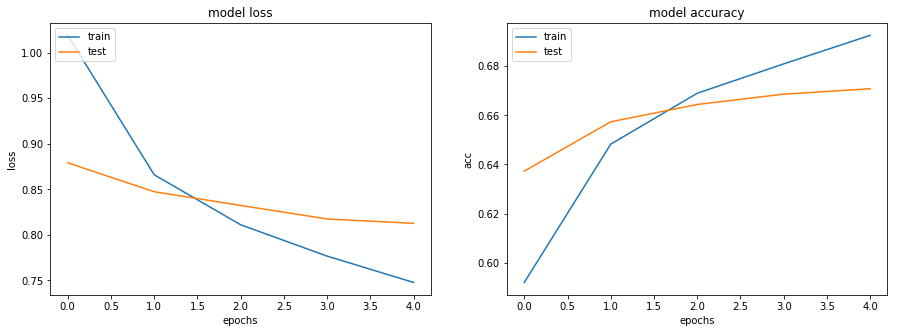

In [87]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.xlabel('epochs')
plt.ylabel('acc')
plt.legend(['train', 'test'], loc='upper left')

plt.show()

In [88]:
from keras.models import load_model

#retrieving model from the checkpoint
best = load_model(model_name)
_, acc = best.evaluate(x_val, y_val)

print("validation accuracy: ", acc)

31212/31212 [==============================] - 39s 1ms/step
validation accuracy:  0.6708317313777259
